Lime - Robot Shop Pattern 2 

In [1]:
# Required Imports 
import pandas as pd 
import numpy as np 
import os 
import matplotlib.pyplot as plt
import json
import time
from datetime import datetime, timedelta
from matplotlib.dates import date2num
from scipy.interpolate import make_interp_spline
import seaborn as sns
import matplotlib.ticker as ticker

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 13}

plt.rc('font', **font)

In [2]:
# https://stackoverflow.com/a/1879011/14626757
# Returns a walked path under collected_data
def f(starting_path):
  alld = {'': {}}

  for dirpath, dirnames, filenames in os.walk(starting_path):
    d = alld
    dirpath = dirpath[len(starting_path):]
    for subd in dirpath.split(os.sep):
      based = d
      d = d[subd]
    if dirnames:
      for dn in dirnames:
        d[dn] = {}
    else:
      based[subd] = filenames
  return alld['']

In [3]:
# standard code to convert data to a timestamp, metric list 
def convert_enddate_to_seconds(ts):
    """Takes ISO 8601 format(string) and converts into epoch time."""
    dt = datetime.datetime.strptime(ts[:-7],'%Y-%m-%dT%H:%M:%S')+\
                datetime.timedelta(hours=int(ts[-5:-3]),
                minutes=int(ts[-2:]))*int(ts[-6:-5]+'1')
    seconds = time.mktime(dt.timetuple()) + dt.microsecond/1000000.0
    return seconds

# returns 2 lists for average values, and timestamp
def get_list(timeseries):
    y = [val['average'] for val in timeseries]
    x = [pd.to_datetime(convert_enddate_to_seconds(val['timeStamp']),unit='s') for val in timeseries]
    return x,y

# Reads data from a filename and returns metrics
def return_time_metric(filename):
    metrics   = []
   
    with open(filename) as f: 
        lines = f.readlines()
        for l in lines:
            # Date 20:55:00+00:00: 11.32125 Time Value
            # 2022-02-25 23:15:00+00:00:
#             Y-M-D H-M
            d,t,v = l.split()
            if not v == "None":
                metrics.append(np.float64(v))                
    timestamp = [i for i in range(0, len(metrics))]            
    return timestamp, metrics
 

def create_graph(x,y,):
    # def clean_plot(data, metric):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    
    ax.plot(x, y)   # 2021-12-31T18:36:00+00:00 2021-12-31T19:05:00+00:00
    
def tolerant_mean(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1), arr.std(axis=-1)

In [4]:
# Generate file listings
filepath = "../collected_data/lime"
api      = os.path.join(filepath, "api")
machine  = os.path.join(filepath, "machine")

api_listing     = f(api)
machine_listing = f(machine)

\\CPU Usage

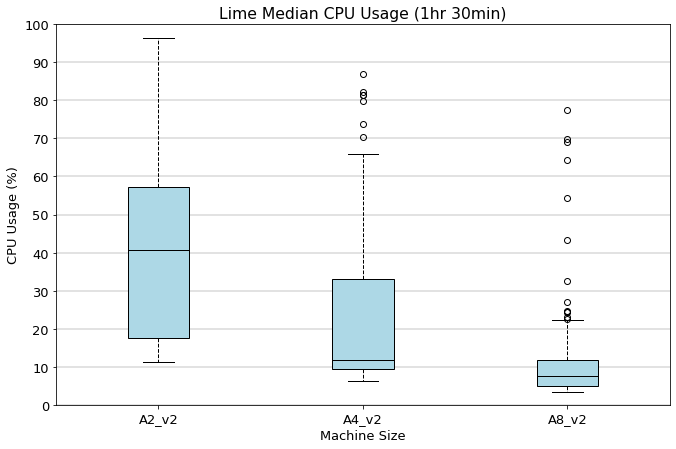

In [25]:
all_cleaned_metrics = []
error = []
for size, iteration in machine_listing.items():
    metrics   = []
    timestamp = 0
    for iteration, files in iteration.items(): 
        temp_path = os.path.join(machine, size, iteration)
        timestamp, metric = return_time_metric(os.path.join(temp_path, "percentageCPU.txt"))
        metrics.append(metric)

    all_metrics = []
    for n in metrics:
        all_metrics.append([float(x) for x in n if x != None])
    mean_metrics , c = tolerant_mean(all_metrics)
    error.append(c)
    all_cleaned_metrics.append(mean_metrics)

# Graph Settings 
fig = plt.figure(figsize =(11, 7))
ax = fig.add_subplot(111)
# plt.boxplot(all_cleaned_metrics[0:3]) 

plt.boxplot(all_cleaned_metrics[0:3], patch_artist=True,  
            boxprops=dict(facecolor="lightblue", color="black"),
            capprops=dict(color="black"),
            whiskerprops=dict(color="black", linestyle='--',),
            flierprops=dict(color="black", markeredgecolor="black"),
            medianprops=dict(color="Black")) 

# ax.set_xticklabels(list(machine_listing.keys())[0:3])
labels = [f"{list(machine_listing.keys())[i][9:]}" for i in range(0, len(list(machine_listing.keys())[0:3]))]
ax.set_xticklabels(labels)
ax.set(xlabel='Machine Size',
           ylabel='CPU Usage (%)',
           title='Lime Median CPU Usage (1hr 30min)')
# Add major gridlines in the y-axis
ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.45, alpha=1)
plt.yticks(np.arange(0, 101, 10))
plt.ylim(0, 100)
plt.show()

Memory Usage

In [13]:
def convert_size(bytes, bsize=1024):
    """convert bytes to megabytes, etc.
       sample code:
           print('mb= ' + str(bytesto(314575262000000, 'm')))
       sample output: 
           mb= 300002347.946
    """

    a = {'k' : 1, 'm': 2, 'g' : 3, 't' : 4, 'p' : 5, 'e' : 6 }
    r = float(bytes)
    for i in range(a['g']):
        r = r / bsize

    return(r)

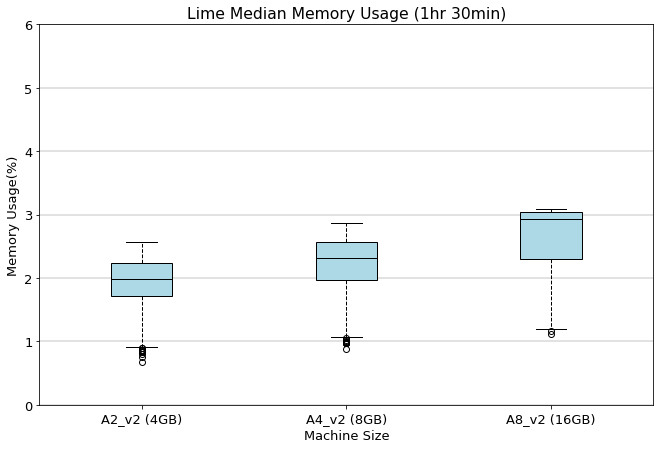

In [26]:
all_cleaned_metrics = []
machine_sizes_mem = [4,8,16,48,64]
n_iter = 0

for size, iteration in machine_listing.items():
    metrics   = []
    timestamp = 0
    for iteration, files in iteration.items(): 
        temp_path = os.path.join(machine, size, iteration)
        timestamp, metric = return_time_metric(os.path.join(temp_path, "availableMemoryBytes.txt"))
        metrics.append(metric)
    
    # get used instead of available 
    all_metrics = []
    for n in metrics:
        all_metrics.append([machine_sizes_mem[n_iter] - convert_size(float(x)) for x in n if x != None])
    n_iter += 1
    mean_metrics , c = tolerant_mean(all_metrics)
    all_cleaned_metrics.append(mean_metrics)
    
# Graph Settings 
fig = plt.figure(figsize =(11, 7))
ax = fig.add_subplot(111)
plt.boxplot(all_cleaned_metrics[0:3], patch_artist=True,  
            boxprops=dict(facecolor="lightblue", color="black"),
            capprops=dict(color="black"),
            whiskerprops=dict(color="black", linestyle='--',),
            flierprops=dict(color="black", markeredgecolor="black"),
            medianprops=dict(color="Black")) 

ax.set_xticklabels(list(machine_listing.keys())[0:3])
labels = [f"{list(machine_listing.keys())[i][9:]} ({machine_sizes_mem[i]}GB)" for i in range(0, len(list(machine_listing.keys())[0:3]))]
ax.set_xticklabels(labels)

ax.set(xlabel='Machine Size',
           ylabel='Memory Usage(%)',
           title='Lime Median Memory Usage (1hr 30min)')
# Add major gridlines in the y-axis
ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.45, alpha=1)
plt.yticks(np.arange(0, 7, 1))
plt.ylim(0, 6) # Kept at 25


plt.show()

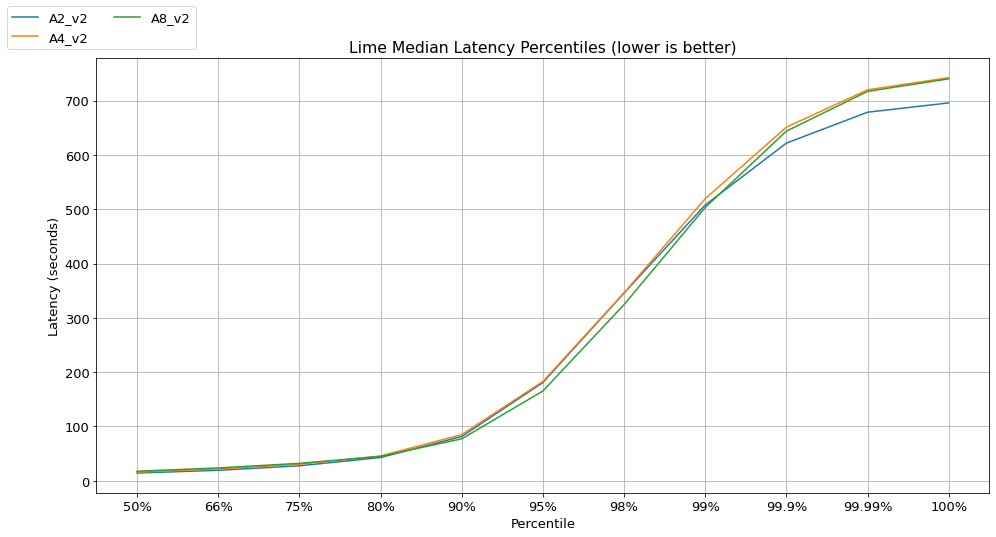

In [29]:
# ## Latency Averages - https://stackoverflow.com/questions/31532546/what-is-the-purpose-of-response-time-distribution-in-locust-io
# It shows the percentage of request completed given time interval which in table below means that 50% of the total requests to home is completed 160ms and 66% of requests are completed in 290ms and respectively goes on.
# You can make a risk analysis about the performance of the services with this table for example to cover 99% 2sec needed but for 100% 14sec 1% of requests has very long time waiting.
# If your target is to have 300ms at most, you can just cover the 66% requests so you will take the risk of your 34% percent of user to lose. 

from scipy.ndimage.filters import gaussian_filter1d

# Latency Average Percentages
plt.show()

fig, ax = plt.subplots(figsize=(16,8))

for size, iteration in api_listing.items():
    if size not in ["standardb16ms","standardb12ms"]:

        new_df = pd.DataFrame(columns=["50%","66%","75%","80%","90%","95%","98%","99%","99.9%","99.99%","100%"])
        percentiles = []
        for iteration, files in iteration.items(): 
            temp_path = os.path.join(api, size, iteration)
            file_name = "load_stats_history.csv"
            df = pd.read_csv(os.path.join(temp_path, file_name))
            df["datetime"] = df["Timestamp"].apply(lambda t: datetime.fromtimestamp(t))
            requests = df[["50%","66%","75%","80%","90%","95%","98%","99%","99.9%","99.99%","100%"]]
            described_requests = requests.mean()
            percentiles.append(list(described_requests.to_dict().values()))

        y, y_err = tolerant_mean(percentiles)
        x = ["50%","66%","75%","80%","90%","95%","98%","99%","99.9%","99.99%","100%"]

        ysmoothed = gaussian_filter1d(y, sigma=1)

        plt.plot(x, ysmoothed)
    
def clean_y(x, pos):
    return int(x/1000)


ticks_y = ticker.FuncFormatter(clean_y)
ax.yaxis.set_major_formatter(ticks_y)
        
ax.set(xlabel='Percentile',
           ylabel='Latency (seconds)',
           title='Lime Median Latency Percentiles (lower is better)')
labels = [f"{list(machine_listing.keys())[i][9:]}" for i in range(0, len(list(machine_listing.keys())))]
plt.legend(bbox_to_anchor=(-0.1, 1.02, 1., .102),
           loc=3, ncol=2,  borderaxespad=0., 
          labels = labels[:3])
plt.grid()
plt.show()


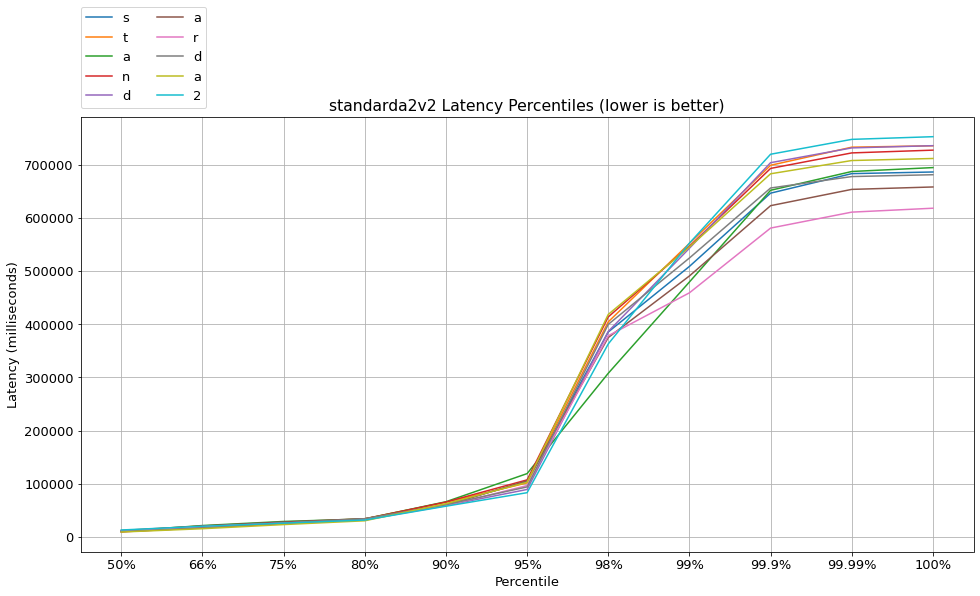

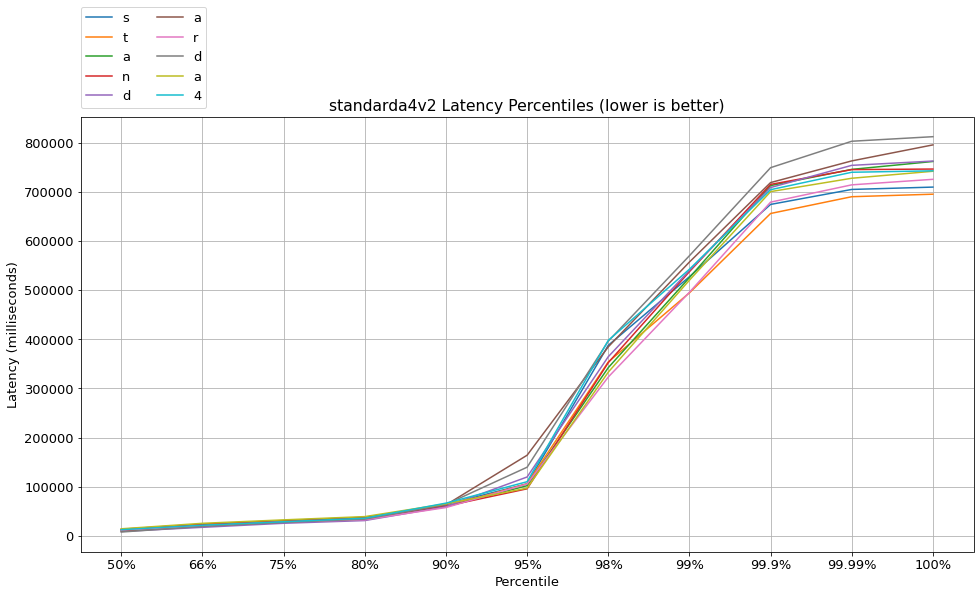

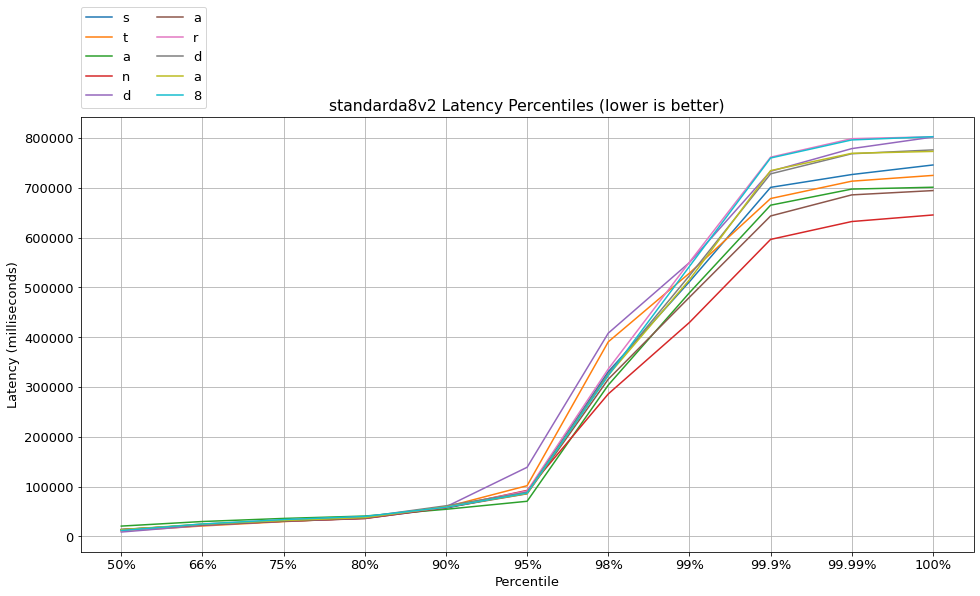

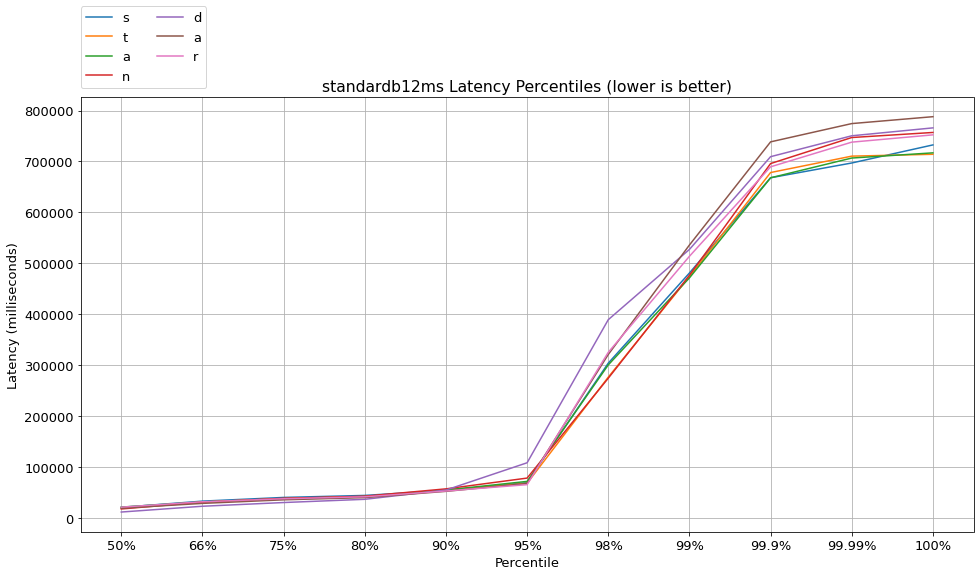

In [22]:
## Latency Averages - Per Machine
# Latency Average Percentages

for size, iteration in api_listing.items():
    fig, ax = plt.subplots(figsize=(16,8))

    new_df = pd.DataFrame(columns=["50%","66%","75%","80%","90%","95%","98%","99%","99.9%","99.99%","100%"])
    percentiles = []
    for iteration, files in iteration.items(): 
        temp_path = os.path.join(api, size, iteration)
        file_name = "load_stats_history.csv"
        df = pd.read_csv(os.path.join(temp_path, file_name))
        df["datetime"] = df["Timestamp"].apply(lambda t: datetime.fromtimestamp(t))
        requests = df[["50%","66%","75%","80%","90%","95%","98%","99%","99.9%","99.99%","100%"]]
        described_requests = requests.mean()
        percentiles.append(list(described_requests.to_dict().values()))

    y, y_err = tolerant_mean(percentiles)

    x = ["50%","66%","75%","80%","90%","95%","98%","99%","99.9%","99.99%","100%"]
    for per in percentiles: 
        plt.plot(x, per)



    ax.set(xlabel='Percentile',
               ylabel='Latency (milliseconds)',
               title=f'{size} Latency Percentiles (lower is better)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102),
               loc=3, ncol=2,  borderaxespad=0., 
              labels = list(size))
    plt.grid()
    plt.show()